## Toolkits 활용 Agent

Langchain 프레임워크를 사용하는 가장 큰 이점은 3rd party integration 되어있는 다양한 기능들을 사용할 수 있다는 점이다.

그 중 Toolkits는 파일을 읽고, 쓰고, 삭제하고, 이동하고, 검색하는 등의 다양한 도구를 통합하여 제공한다.

- Source
    - [Agent Toolkits](https://api.python.langchain.com/en/latest/community/agent_toolkits.html)
    - [Tools](https://python.langchain.com/docs/integrations/tools/)

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
from langchain_teddynote import logging
logging.langsmith("toolkits-agent")

LangSmith 추적을 시작합니다.
[프로젝트명]
toolkits-agent


먼저 임시 폴더를 생성한다.

In [3]:
import os

if not os.path.exists("tmp"):
    os.makedirs("tmp")  # tmp는 temporary의 약자

### FileManagementToolkit

`FileManagementToolkit`은 파일 관리를 위한 도구들을 제공한다.

#### Elements
1. **파일 관리 도구**
    - `CopyFileTool` : 파일을 복사하는 도구
    - `DeleteFileTool` : 파일을 삭제하는 도구
    - `FileSearchTool` : 파일을 검색하는 도구
    - `MoveFileTool` : 파일을 이동하는 도구
    - `ReadFileTool` : 파일을 읽는 도구
    - `WriteFileTool` : 파일을 쓰는 도구
    - `ListDirectoryTool` : 디렉토리 목록을 조회하는 도구
2. **설정**
    - `root_dir` : 파일 작업의 루트 디렉토리 설정
    - `selected_tools` : 특정 도구만 선택적으로 사용 가능
3. **동적 도구 생성**
    - `get_tools` : 메서드로 선택된 도구들의 인스턴스 생성

이 `FilesManagementToolkit`은 로컬 파일 관리 작업을 자동화하거나 AI Agent에게 파일 조작 능력을 부여할 때 매우 유용하게 사용할 수 있다.

**단, 보안측면에서 신중한 접근이 필요하다.**

In [5]:
# FileManagementToolkit 가져오기 : 이 도구는 파일 관리 작업을 수행하는데 사용
from langchain_community.agent_toolkits import FileManagementToolkit

# 'tmp'라는 이름의 디렉토리를 작업 디렉토리로 설정
working_directory = "tmp" # 경로

# FileManagementToolkit 인스턴스 생성
# root_dir 매개 변수에 작업 디렉토리를 지정하여 모든 파일 작업이 이 디렉토리 내에서 이루어지도록 한다.
toolkit= FileManagementToolkit(root_dir=str(working_directory))

# toolkit.get_tools() 메서드를 호출하여 사용가능한 도구 목록을 가져온다.
# 이 도구들은 파일 복사, 삭제, 검색, 이동, 읽기, 쓰기, 디렉토리 목록 조회 등의 기능을 제공.
available_tools = toolkit.get_tools()

# 생성된 도구들을 출력
print("< 사용가능한 파일도구들 >")
for tool in available_tools:
    print(f"- {tool.name} : {tool.description}")

< 사용가능한 파일도구들 >
- copy_file : Create a copy of a file in a specified location
- file_delete : Delete a file
- file_search : Recursively search for files in a subdirectory that match the regex pattern
- move_file : Move or rename a file from one location to another
- read_file : Read file from disk
- write_file : Write file to disk
- list_directory : List files and directories in a specified folder


In [6]:
# 도구 중 일부만 지정하여 선택하는것도 가능하다
tools = FileManagementToolkit(
    root_dir=str(working_directory),
    selected_tools=["read_file", "file_delete", "write_file", "list_directory"]
).get_tools()

tools

[ReadFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp')]

In [7]:
read_tool, delete_tool, write_tool, list_tool = tools

In [13]:
# 파일쓰기
write_tool.invoke({"file_path": "read_example_1.txt", "text": "Hello, World!"})

'File written successfully to read_example_1.txt.'

In [17]:
# 파일읽기
read_tool.invoke({"file_path": "read_example.txt"})
# 파일삭제
delete_tool.invoke({"file_path": "read_example_1.txt"})

'File deleted successfully: read_example_1.txt.'

In [14]:
# 디렉토리 목록 조회
list_tool.invoke({})

'read_example_1.txt\nread_example.txt'

### 뉴스를 검색 후 toolkit을 사용하여 파일로 저장 및 출력 + chat_history 저장

In [18]:
from langchain.tools import tool
from typing import List, Dict
from langchain_teddynote.tools import GoogleNews

# 최신 뉴스 검색
@tool
def latest_news(k: int = 5) -> List[Dict[str, str]]:
    """Look up latest news"""
    # googlenews 객체 생성
    news_tool = GoogleNews()
    # 최신 뉴스 검색 후 결과 반환. 
    return news_tool.search_latest(k=k)

# filemanagementtoolkit 사용하여 파일 관리도구 가져오기
tools = FileManagementToolkit(
    root_dir=str(working_directory)
).get_tools()

# 최신 뉴스 검색 도구를 tools 리스트에 추가
tools.append(latest_news)

tools

[CopyFileTool(root_dir='tmp'),
 DeleteFileTool(root_dir='tmp'),
 FileSearchTool(root_dir='tmp'),
 MoveFileTool(root_dir='tmp'),
 ReadFileTool(root_dir='tmp'),
 WriteFileTool(root_dir='tmp'),
 ListDirectoryTool(root_dir='tmp'),
 StructuredTool(name='latest_news', description='Look up latest news', args_schema=<class 'langchain_core.utils.pydantic.latest_news'>, func=<function latest_news at 0x10f9c42c0>)]

In [19]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent, AgentExecutor
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from langchain_teddynote.messages import AgentStreamParser

# session Id 저장 딕셔너리
store = {}

prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        "You are a helpful assistant."
        "Make sure to use the `latest_news` tool to find latest news."
        "Make sure to use the `file_management` tool to manage files."
    ),
    ("placeholder", "{chat_history}"),
    ("human", "{input}"),
    ("placeholder", "{agent_scratchpad}"),
])

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.78)

agent = create_tool_calling_agent(llm, tools, prompt)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True
)

# session_id 기반으로 세션 기록 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]

# 채팅 메시지 기록이 추가된 에이전트 생성
agent_with_history = RunnableWithMessageHistory(
    agent_executor,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
)

agent_stream_parser = AgentStreamParser()

In [23]:
result = agent_with_history.stream(
    {"input": "최신뉴스 5개를 검색하고, 각 뉴스의 제목을 파일명으로 가지는 파일을 생성해줘. 확장자는 txt로 해줘."
     "파일의 내용 안에 뉴스 기사의 속내용과 url도 추가해줘."},
     config = {"configurable": {"session_id": "1234"}}
)

for step in result :
    agent_stream_parser.process_agent_steps(step)

[도구 호출]
Tool: latest_news
k: 5
Log: 
Invoking: `latest_news` with `{'k': 5}`



[관찰 내용]
Observation: [{'url': 'https://news.google.com/rss/articles/CBMihgFBVV95cUxQakc2VzBxTzMzdnBveTlrSkRaekNwa0h1czQtR1kxOS02eTBITmxDZjVQZ3V0RVFWRWZNdWtwd3ZuOEdDNE04RmgyWmFkc2FSMHhZU1pEQXhzOGx5aVp3VlBpbThlOWFIN2E2ZFZYZ2p5VS1seVVrQUl4Nm9UN3I5alphTG9IQdIBmgFBVV95cUxQYkYxOVdjOGtQSjVwUTBHTXVkeEdhSmhSbHk4RFZXQk9LU21zMUhDYmVxSl9jYjl6cWhuY2JHWE1OSmdVdmxGUWkyNUg4R2wtYVA2eUhScEFfcHViZjFQRUo2cTBCbVlHODJOR0FIaGhJb2Y4ODVCSWpaRldpWEFRdEh5UlZJekxLWURmZGdxUTdVcHVpUTNjbjRB?oc=5', 'content': '권영세 “헌법재판관들, 특정 세력과 특수관계… 국민들이 못믿어” - 조선일보'}, {'url': 'https://news.google.com/rss/articles/CBMiWkFVX3lxTFBScEQtYVhjRDF1SktKM0FwUUVsVm00Q1ZHcGZ1cUxyQUpHbDlLSW9oLUp6U3dQcFNmUnFPdEdBbEstbnZKblQya2xPS2x3cFVwQVM3TkpZdlUxQdIBVEFVX3lxTE5ydjVGVF9ScERpcnFocFFmQ2JkS2NJanhwVkJ3WGppVUlPRGRMb2sxQjBXWjNGTF9wSURVRzBFdmFoUXQzNzlaeldLOEVVMTJXekpsSQ?oc=5', 'content': '尹 "여기도 사람 사는 곳"…정진석 등 대통령실 참모들과 접견 - 한국경제'}, {'url': 'https://news.google.com/rss/

In [24]:
result = agent_with_history.stream(
    {"input": 
     "이전에 생성해놓은 파일 제목 맹앞에 제목에 어울리는 emoji를 추가하고, 파일명도 깔끔하게 변경해줘."
     },
     config = {"configurable": {"session_id": "1234"}}
)

for step in result :
    agent_stream_parser.process_agent_steps(step)

[도구 호출]
Tool: file_search
pattern: *.txt
Log: 
Invoking: `file_search` with `{'pattern': '*.txt'}`



[관찰 내용]
Observation: 尹_여기도_사람_사는_곳.txt
이재명_민생지원금_때문에_추경_못한다면_‘전국민_25만원’_포기.txt
미국_여객기_사고에_일본,_162명_전원_숨진_54년_전_악몽_상기.txt
권영세_헌법재판관들_특정_세력과_특수관계.txt
삼성전자_지난해_4분기_연간_확정_실적_발표.txt
[도구 호출]
Tool: move_file
source_path: 권영세_헌법재판관들_특정_세력과_특수관계.txt
destination_path: 🧑‍⚖️_헌법재판관들_특정_세력과_특수관계.txt
Log: 
Invoking: `move_file` with `{'source_path': '권영세_헌법재판관들_특정_세력과_특수관계.txt', 'destination_path': '🧑\u200d⚖️_헌법재판관들_특정_세력과_특수관계.txt'}`



[도구 호출]
Tool: move_file
source_path: 尹_여기도_사람_사는_곳.txt
destination_path: 🏢_여기도_사람_사는_곳.txt
Log: 
Invoking: `move_file` with `{'source_path': '尹_여기도_사람_사는_곳.txt', 'destination_path': '🏢_여기도_사람_사는_곳.txt'}`



[도구 호출]
Tool: move_file
source_path: 삼성전자_지난해_4분기_연간_확정_실적_발표.txt
destination_path: 📊_지난해_4분기_연간_확정_실적_발표.txt
Log: 
Invoking: `move_file` with `{'source_path': '삼성전자_지난해_4분기_연간_확정_실적_발표.txt', 'destination_path': '📊_지난해_4분기_연간_확정_실적_발표.txt'}`



[도구 호출]
Tool: move_

In [25]:

result = agent_with_history.stream(
    {
        "input": "이전에 생성한 모든 파일을 `news` 폴더를 생성한 뒤 해당 폴더에 모든 파일을 복사하세요. "
        "내용도 동일하게 복사하세요. "
    },
    config={"configurable": {"session_id": "1234"}},
)

for step in result:
    agent_stream_parser.process_agent_steps(step)

[도구 호출]
Tool: list_directory
Log: 
Invoking: `list_directory` with `{}`



[관찰 내용]
Observation: ✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
🧑‍⚖️_헌법재판관들_특정_세력과_특수관계.txt
🏢_여기도_사람_사는_곳.txt
📊_지난해_4분기_연간_확정_실적_발표.txt
💰_민생지원금_추경_포기.txt
[도구 호출]
Tool: copy_file
source_path: ✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
destination_path: news/✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
Log: 
Invoking: `copy_file` with `{'source_path': '✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt', 'destination_path': 'news/✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt'}`



[관찰 내용]
Observation: Error: [Errno 2] No such file or directory: '/Users/ruahkim/coding/study/langchain/03_agent/tmp/news/✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt'
[도구 호출]
Tool: file_search
dir_path: news
pattern: *
Log: 
Invoking: `file_search` with `{'dir_path': 'news', 'pattern': '*'}`



[관찰 내용]
Observation: No files found for pattern * in directory news
[도구 호출]
Tool: write_file
file_path: news/✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
text: 
append: False
Log: 
Invoking: `write_file` with `{'file_path': 

In [26]:

result = agent_with_history.stream(
    {"input": "news 폴더를 제외한 모든 .txt 파일을 삭제하세요."},
    config={"configurable": {"session_id": "1234"}},
)

print("Agent 실행 결과:")
for step in result:
    agent_stream_parser.process_agent_steps(step)

Agent 실행 결과:
[도구 호출]
Tool: file_search
pattern: *.txt
Log: 
Invoking: `file_search` with `{'pattern': '*.txt'}`



[관찰 내용]
Observation: ✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
🧑‍⚖️_헌법재판관들_특정_세력과_특수관계.txt
🏢_여기도_사람_사는_곳.txt
📊_지난해_4분기_연간_확정_실적_발표.txt
💰_민생지원금_추경_포기.txt
news/✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
news/🧑‍⚖️_헌법재판관들_특정_세력과_특수관계.txt
news/🏢_여기도_사람_사는_곳.txt
news/📊_지난해_4분기_연간_확정_실적_발표.txt
news/💰_민생지원금_추경_포기.txt
[도구 호출]
Tool: file_delete
file_path: ✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt
Log: 
Invoking: `file_delete` with `{'file_path': '✈️_여객기_사고_162명_전원_숨진_54년_전_악몽.txt'}`



[도구 호출]
Tool: file_delete
file_path: 🧑‍⚖️_헌법재판관들_특정_세력과_특수관계.txt
Log: 
Invoking: `file_delete` with `{'file_path': '🧑\u200d⚖️_헌법재판관들_특정_세력과_특수관계.txt'}`



[도구 호출]
Tool: file_delete
file_path: 🏢_여기도_사람_사는_곳.txt
Log: 
Invoking: `file_delete` with `{'file_path': '🏢_여기도_사람_사는_곳.txt'}`



[도구 호출]
Tool: file_delete
file_path: 📊_지난해_4분기_연간_확정_실적_발표.txt
Log: 
Invoking: `file_delete` with `{'file_path': '📊_지난해_4분기_연간_확정_실적_발표.txt'}`



`tmp` 폴더 내부를 확인해보면 아래와 같이 news 폴더를 제외한 모든 파일이 삭제된 것을 확인할 수 있다.

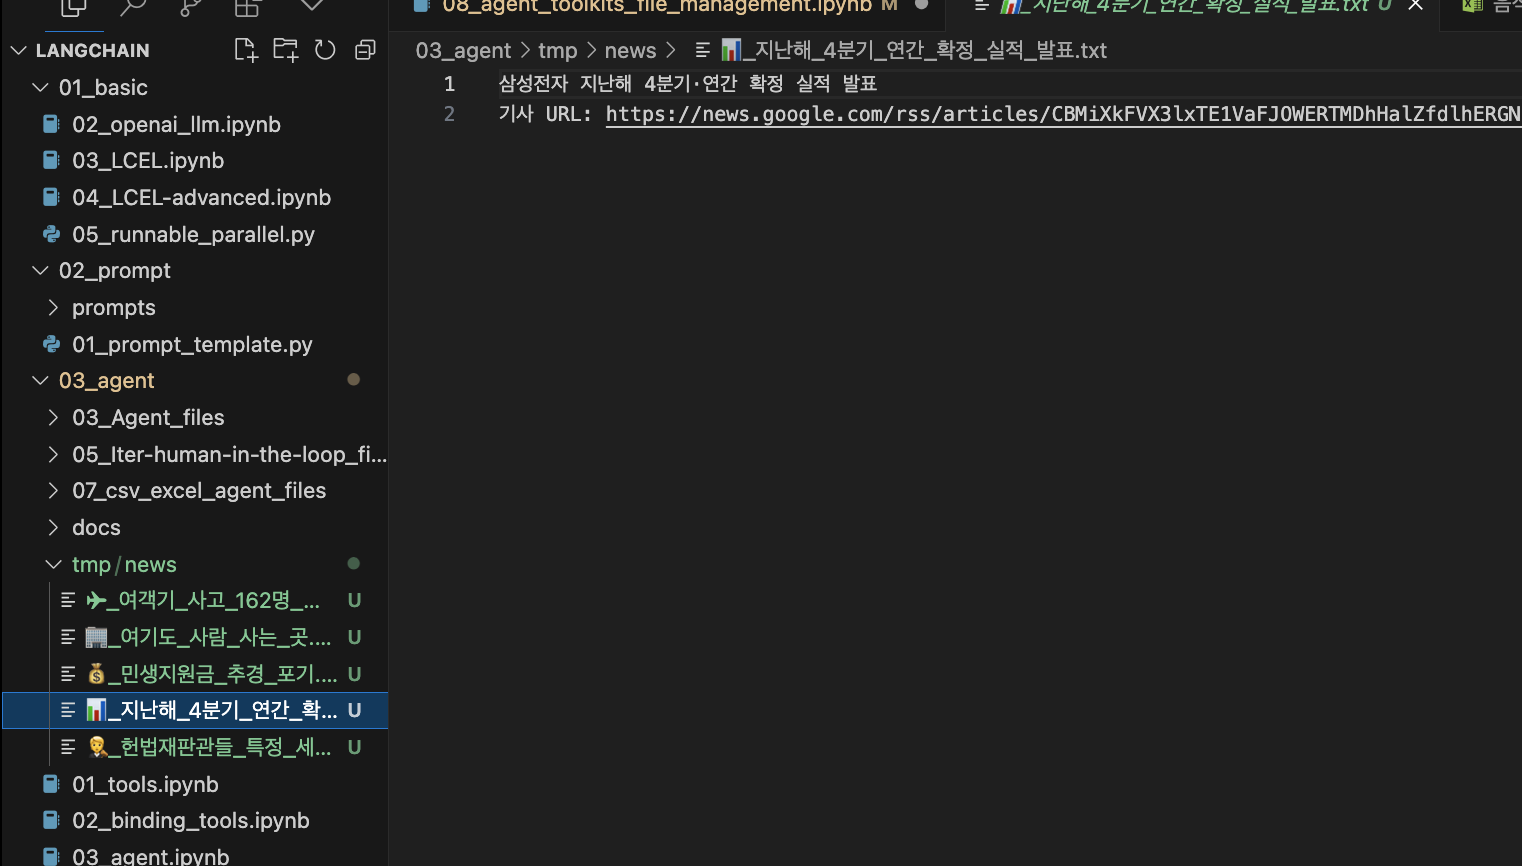